# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')


from hw2_code import DecisionTree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
import seaborn as sns

palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

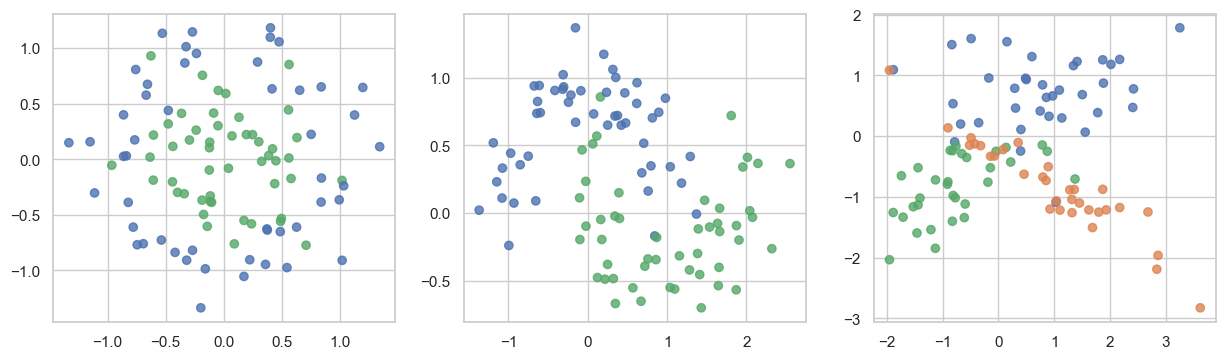

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

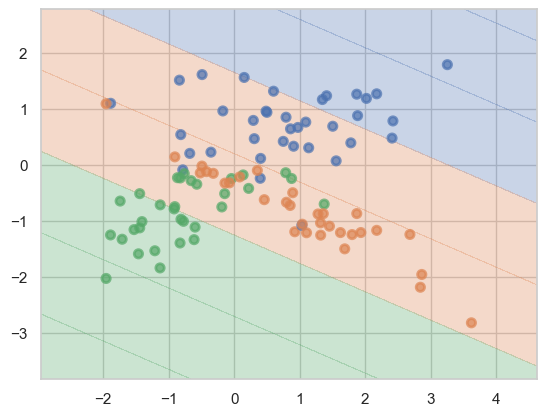

In [ ]:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

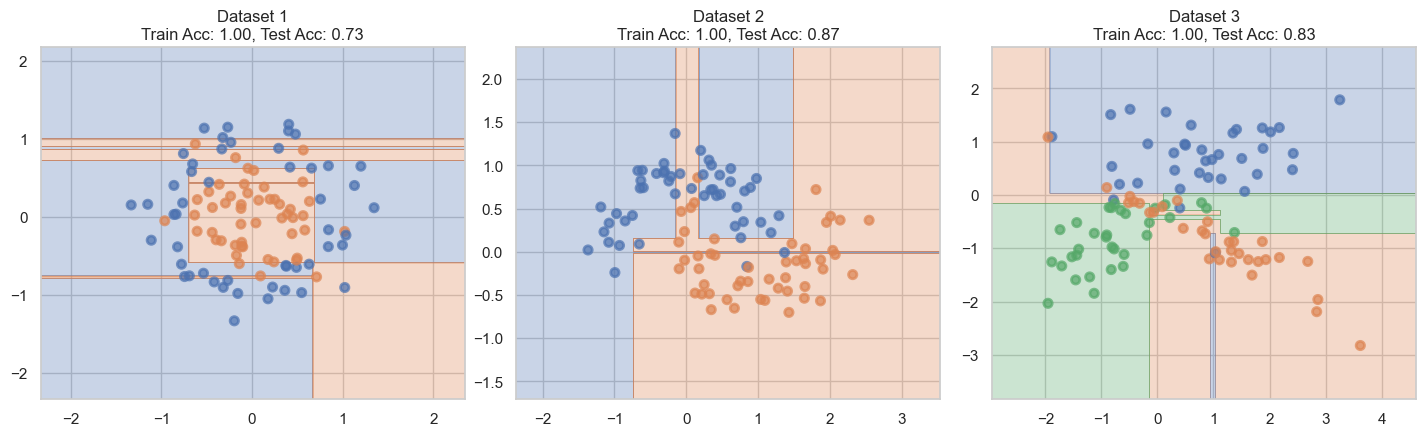

In [ ]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 5))
for i, (x, y) in enumerate(datasets):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    plt.subplot(1, 3, i + 1)
    plot_surface(clf, x, y)
    plt.title(f"Dataset {i+1}\nTrain Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}")
    
plt.show()

__Ответ:__ Деревья с параметрами по умолчанию строят очень сложные разделяющие поверхности, пытаясь идеально классифицировать каждый объект обучающей выборки. Это приводит к переобучению: train accuracy равна = 1, а test accuracy ниже. Визуально это проявляется в виде узких полосок и островов классов.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

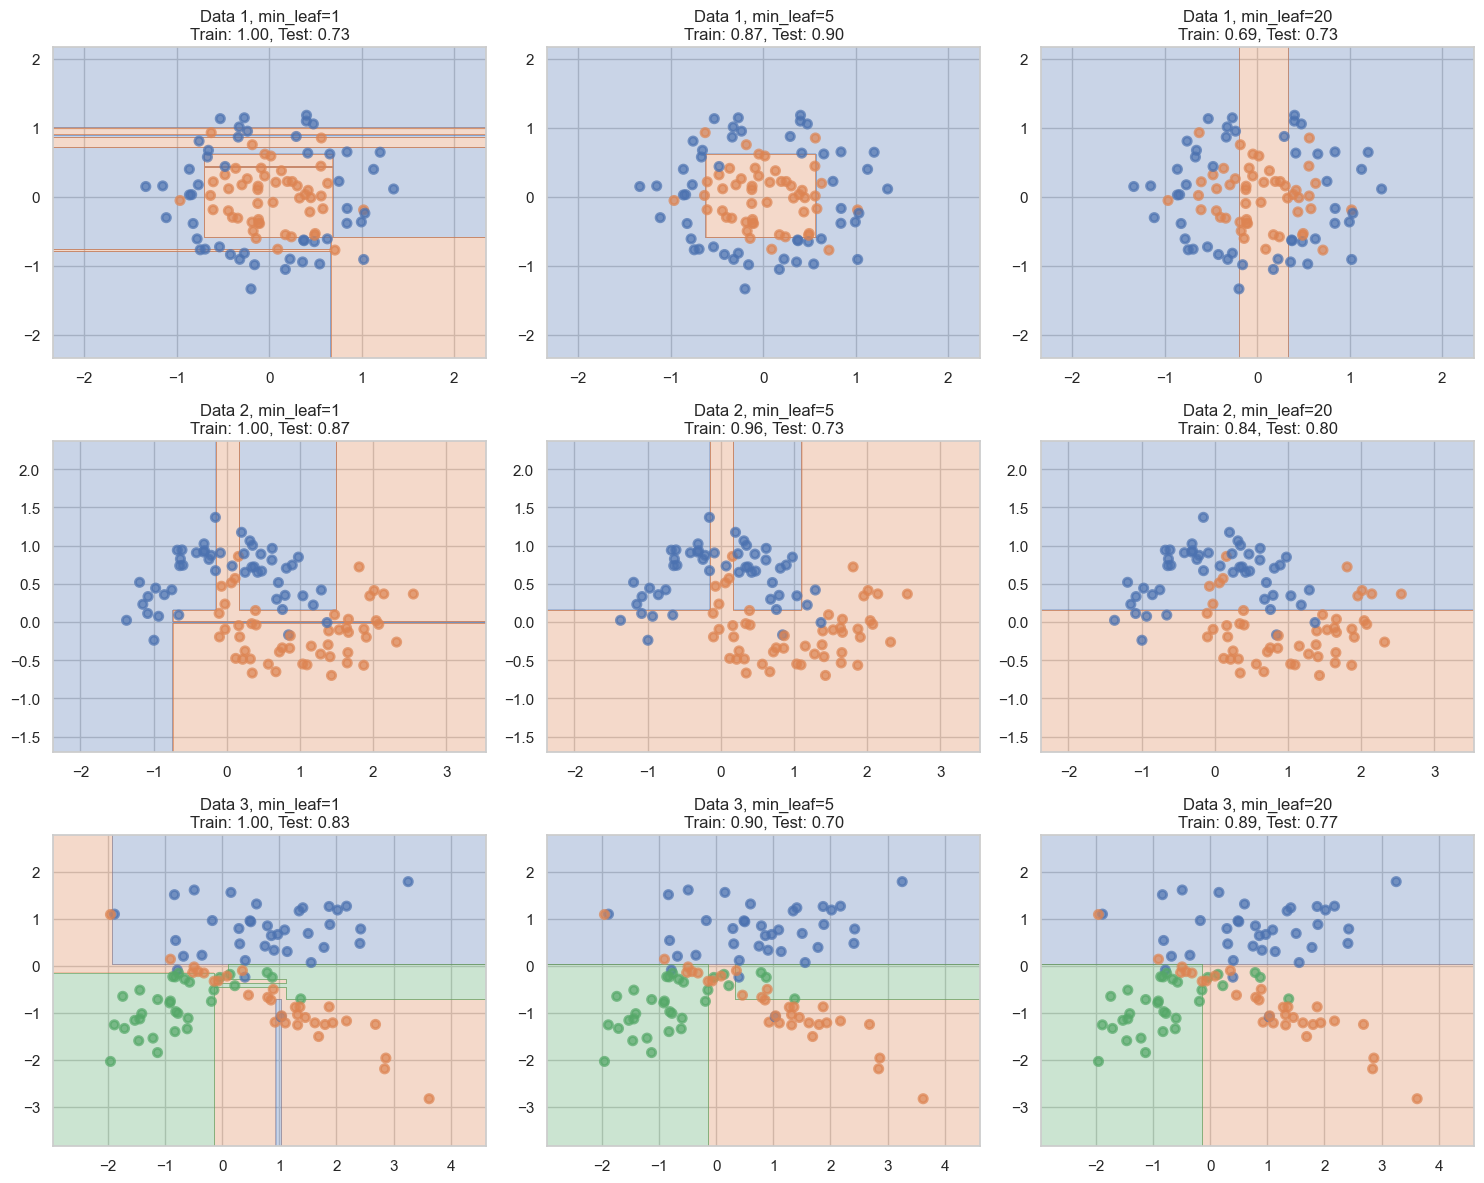

In [ ]:
min_samples_leaf_vals = [1, 5, 20]

plt.figure(figsize=(15, 12))
plot_idx = 1

for i, (x, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    for min_samples in min_samples_leaf_vals:
        clf = DecisionTreeClassifier(min_samples_leaf=min_samples, random_state=42)
        clf.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))
        
        plt.subplot(3, 3, plot_idx)
        plot_surface(clf, x, y)
        plt.title(f"Data {i+1}, min_leaf={min_samples}\nTrain: {train_acc:.2f}, Test: {test_acc:.2f}")
        plot_idx += 1
plt.tight_layout()
plt.show()

__Ответ:__ Увеличение min_samples_leaf или ограничение max_depth работает как регуляризация. Разделяющие поверхности становятся более гладкими и простыми. "Островки" исчезают.
На обучающей выборке accuracy падает.
На тестовой выборке accuracy обычно растет (до определенного момента), так как модель перестает запоминать шум.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

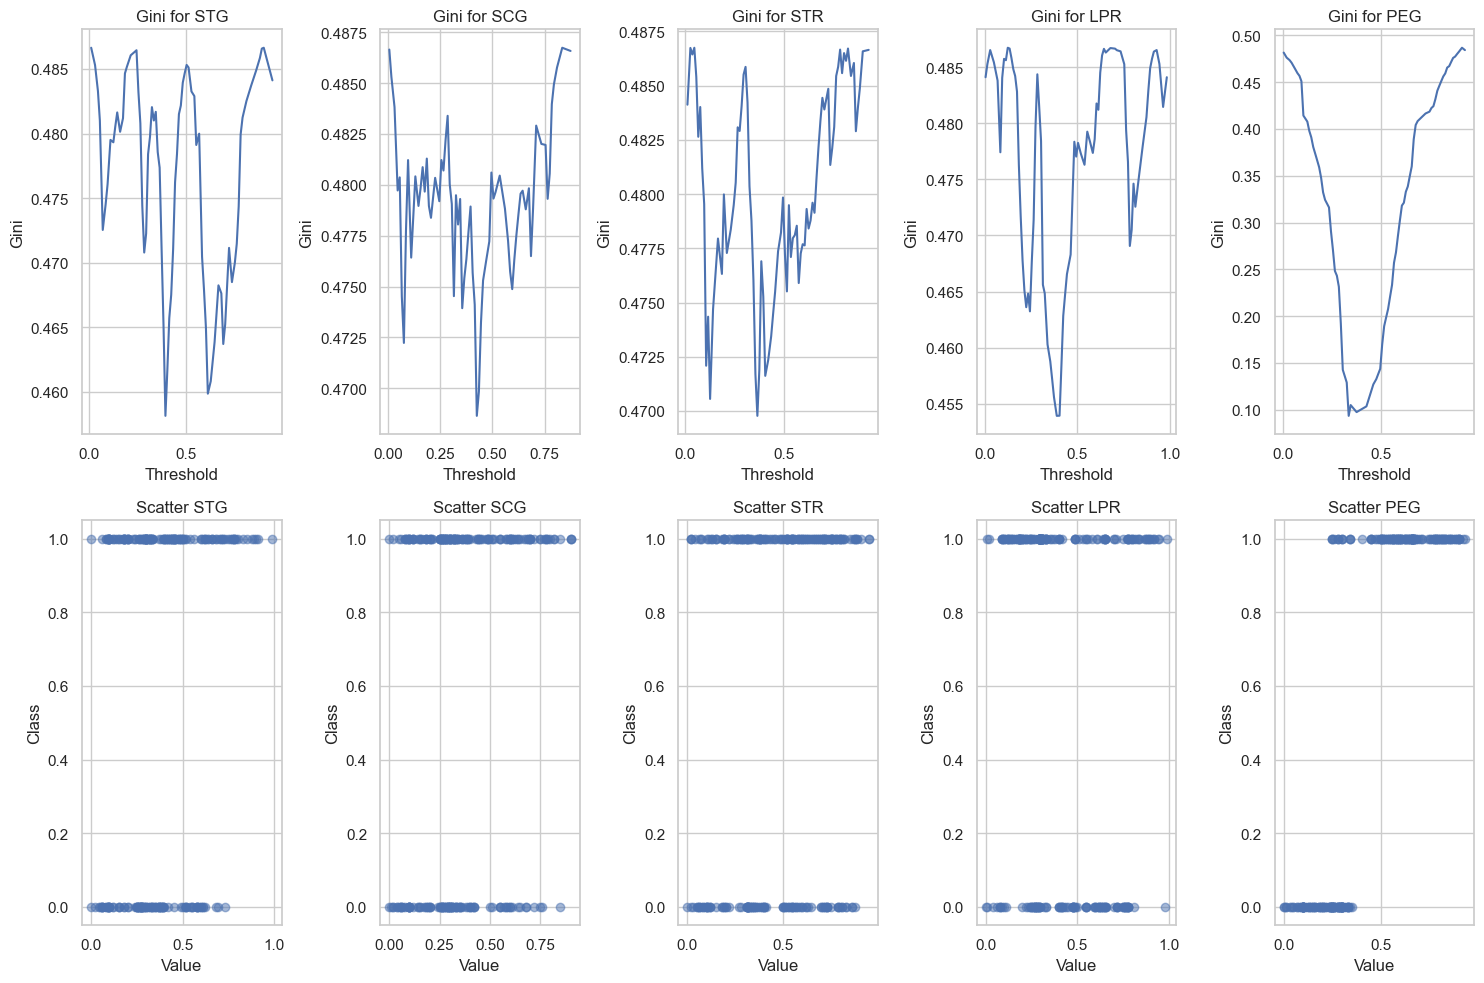

In [ ]:
from hw2_code import find_best_split

df = pd.read_csv('datasets/students.csv')
target = df['UNS'].values
features = df.drop('UNS', axis=1)

plt.figure(figsize=(15, 10))

for i, col in enumerate(features.columns):
    feature_vector = features[col].values
    thresholds, ginis, _, _ = find_best_split(feature_vector, target)
    
    # Gini
    plt.subplot(2, 5, i + 1)
    plt.plot(thresholds, ginis)
    plt.title(f"Gini for {col}")
    plt.xlabel("Threshold")
    plt.ylabel("Gini")
    
    # Scatter
    plt.subplot(2, 5, i + 6)
    plt.scatter(feature_vector, target, alpha=0.5)
    plt.title(f"Scatter {col}")
    plt.xlabel("Value")
    plt.ylabel("Class")

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
- Лучший признак - PEG. Кривая похожа на параболу. Функция имеет глубокий и единственный четкий минимум - критерий Джини - 0.1 примерно. Значит бинарное раздедение по этому признаку сработало хорошо. На scatter-графике тоже видно четкое разделние. Слева value 0, справа 1.

- Остальные признаки показывают хаотичный график, на scatter-графиках тоже каша. Деление по таким признакам показывают плохую чистоту выборки.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

done

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [26]:
df_mush = pd.read_csv('datasets/agaricus-lepiota.data', header=None)

le = LabelEncoder()
for col in df_mush.columns:
    df_mush[col] = le.fit_transform(df_mush[col])

# 0 столбец - таргет
X = df_mush.iloc[:, 1:].values
y = df_mush.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# все признаки категориальные
types = ["categorical"] * x_train.shape[1]
tree = DecisionTree(feature_types=types)

tree.fit(x_train, y_train)

preds = tree.predict(x_test)
acc = accuracy_score(y_test, preds)
print(f"accuracy: {acc}")


accuracy: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

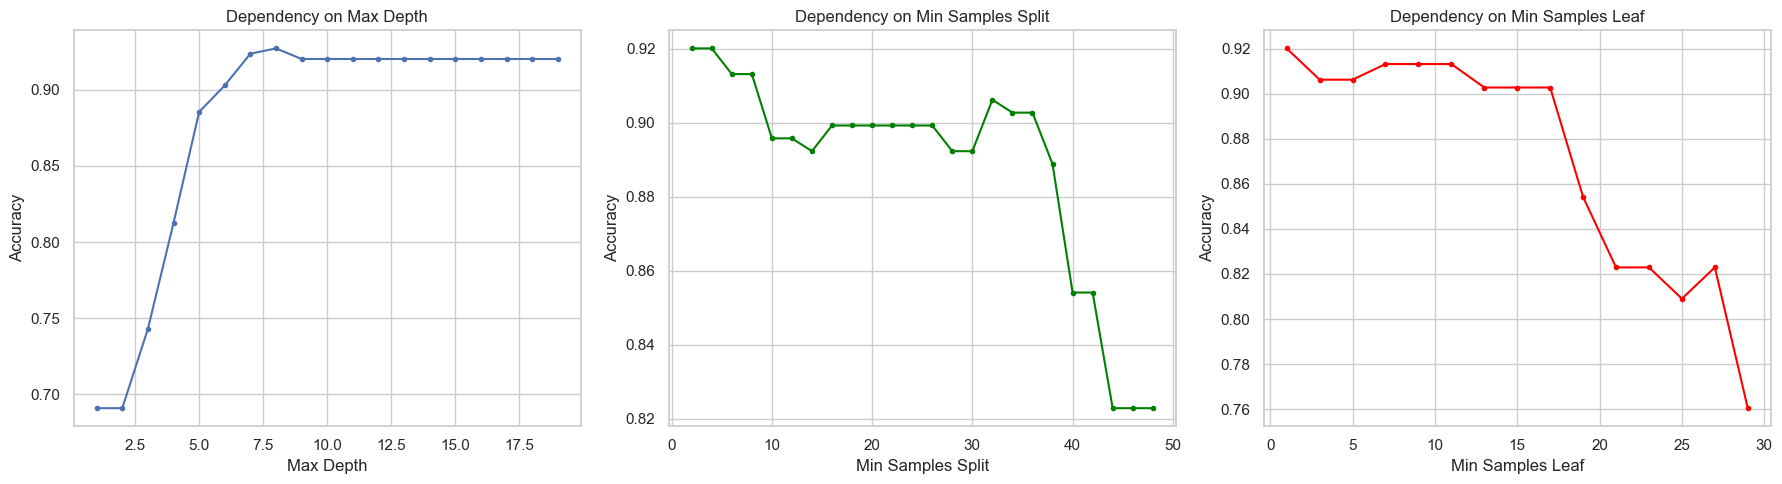

In [27]:
df_ttt = pd.read_csv('datasets/tic-tac-toe-endgame.csv')

le = LabelEncoder()
for col in df_ttt.columns:
    df_ttt[col] = le.fit_transform(df_ttt[col])

x = df_ttt.iloc[:, :-1].values
y = df_ttt.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


types = ["categorical"] * X.shape[1]

depths = range(1, 20)
min_splits = range(2, 50, 2)
min_leaves = range(1, 30, 2)

acc_depth = []
acc_split = []
acc_leaf = []


# Считаем
for d in depths:
    dt = DecisionTree(feature_types=types, max_depth=d)
    dt.fit(x_train, y_train)
    acc_depth.append(accuracy_score(y_test, dt.predict(x_test)))


for s in min_splits:
    dt = DecisionTree(feature_types=types, min_samples_split=s)
    dt.fit(x_train, y_train)
    acc_split.append(accuracy_score(y_test, dt.predict(x_test)))


for l in min_leaves:
    dt = DecisionTree(feature_types=types, min_samples_leaf=l)
    dt.fit(x_train, y_train)
    acc_leaf.append(accuracy_score(y_test, dt.predict(x_test)))


# графики
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# max_depth
axes[0].plot(depths, acc_depth, marker='.')
axes[0].set_xlabel("Max Depth")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Dependency on Max Depth")
axes[0].grid(True)

# min_samples_split
axes[1].plot(min_splits, acc_split, marker='.', color='green')
axes[1].set_xlabel("Min Samples Split")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Dependency on Min Samples Split")
axes[1].grid(True)

# min_samples_leaf
axes[2].plot(min_leaves, acc_leaf, marker='.', color='red')
axes[2].set_xlabel("Min Samples Leaf")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Dependency on Min Samples Leaf")
axes[2].grid(True)

plt.tight_layout()
plt.show()

Точность растет до глубины 8-9 - как раз количество ходов в крестиках ноликах.
Регуляризация в данном юзкейсе вредна, тк усреднять выигрышные ходы вместе с проигрышными в одном листе нерезонно. Дерево должно иметь возможность создавать листья для конкретных уникальных комбинаций.

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer


def load_and_prep(name, url, target_idx=-1):
    df = pd.read_csv(url, header=None)
    
    X = df.iloc[:, :target_idx] if target_idx == -1 else df.iloc[:, 1:]
    y = df.iloc[:, target_idx] if target_idx == -1 else df.iloc[:, 0]
    
    y = LabelEncoder().fit_transform(y)
    
    X_le = X.copy()
    for col in X_le.columns:
        X_le[col] = LabelEncoder().fit_transform(X_le[col])
    
    # для OHE
    ohe = OneHotEncoder(sparse_output=False) # sparse=False для простоты
    X_ohe = ohe.fit_transform(X)
    
    return X_le.values, X_ohe, y

datasets_info = [
    ("mushrooms", "datasets/agaricus-lepiota.data"),
    ("tic-tac-toe", "datasets/tic-tac-toe-endgame.csv"),
    ("cars", "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"),
    ("nursery", "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data")
]

results = []
scorer = make_scorer(accuracy_score)

for name, url in datasets_info:
    try:
        print(f"Processing {name}...")
        
        X_le, X_ohe, y = load_and_prepare_data(name, url)
        
        dt_real = DecisionTree(feature_types=["real"] * X_le.shape[1])
        dt_cat = DecisionTree(feature_types=["categorical"] * X_le.shape[1])
        dt_ohe = DecisionTree(feature_types=["real"] * X_ohe.shape[1])
        sk_tree = DecisionTreeClassifier(random_state=42)
        
        acc_real = cross_val_score(dt_real, X_le, y, cv=10, scoring=scorer).mean()
        acc_cat = cross_val_score(dt_cat, X_le, y, cv=10, scoring=scorer).mean()
        acc_ohe_custom = cross_val_score(dt_ohe, X_ohe, y, cv=10, scoring=scorer).mean()
        acc_sklearn = cross_val_score(sk_tree, X_le, y, cv=10, scoring=scorer).mean()
        
        results.append({
            "Dataset": name,
            "Custom Real": acc_real,
            "Custom Cat": acc_cat,
            "Custom OHE": acc_ohe_custom,
            "Sklearn LE": acc_sklearn
        })
        
    except Exception as e:
        print(f"Error on {name}: {e}")
        import traceback
        traceback.print_exc()

res_df = pd.DataFrame(results).set_index("Dataset")
display(res_df)


Processing mushrooms...
Processing tic-tac-toe...
Processing cars...
Processing nursery...


,Custom Real,Custom Cat,Custom OHE,Sklearn LE
Dataset,,,,
mushrooms,0.999261,0.999877,0.999631,0.960384
tic-tac-toe,0.426820,0.590450,0.523761,0.771678
cars,0.949009,0.966978,0.908496,0.942707
nursery,0.999691,0.999846,0.999846,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Ранжирование алгоритмов сильно отличается для разных данных. На одних наборах все методы работают почти одинаково хорошо. В крестиках-ноликах разница большая

Когда имеем дело с данными, где есть естественный порядок, то и простое кодирование числами работает нормально. А вот в чисто категориальных данных, как позиции на игровом поле, только специальные алгоритмы понимают, как правильно с ними работать.

Случайность присутствует. Деревья решений могут по-разному сплититься в зависимости от начальных условий. На это можно влиять - подбирать параметры деревьев, увеличивать количество проверок. 

Крч, нужно дереву указывать конкретно с какими признаками работаем и не пытаться одним универсальным методом решать все задачи.

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания:

Понравился анализ разных параметров для крестиков ноликов, где победу нельзя смешивать с проигрышными.
Приколько, что от глубину тоже можно ограничить, так как в крестиках ноликах это не иммет смысла. Просто забавно.
Графики gini и scatter тоже прикольные.